# mflow Demonstration 2

Running this notebook takes about 6-1/2 minutes on a Mid-2014 MacBook Pro

### Data Scientist Responsibility
This notebook demonstrates performing hyper-parameter optimization using randomized cross-validation on several algorithms, which conforms to the scikit-learn learn api structure, and using mlflow to record the optimal hyper-parameters, model training results and data sets used in training.

The algorithms used are
* sklearn ElasticNet
* sklearn RandomForestRegressor
* sklearn ExtraTreesRegressor
* sklearn MLPRegressor
* xgboost XGBRegressor

Each algorithm is executed as a mlflow Run.

The train/test data sets used in a Run are saved as an mlflow artifact.

The mlflow experiment is organized into 3 sets of runs.  Each run set trains the algorithms on a specific format of the training data:
* raw values
* Values are standardized: mean centered / scaled by standard deviaion
* Values are transformed to range $[0, 1]$

### mlflow Functionality
The mlflow tracking server is used to record experimental results: hyper-parameters, metrics and modeling artifacts.



In [1]:
from __future__ import print_function

In [2]:
import yaml
import os.path
import socket
import pandas as pd
import tempfile
import pickle
import shutil
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import mlflow
import mlflow.sklearn


## Set up training and test data sets

In [3]:
#%%
# Read the wine-quality csv file (make sure you're running this from the root of MLflow!)
data = pd.read_csv("./wine-quality.csv")

# Split the data into training and test sets. (0.75, 0.25) split.
train, test = train_test_split(data,random_state=13)

# The predicted column is "quality" which is a scalar from [3, 9]
train_x = train.drop(["quality"], axis=1)
test_x = test.drop(["quality"], axis=1)
train_y = train[["quality"]]
test_y = test[["quality"]]


###
# Custom Transformer class to return values of dataframe as numpy array
###
class NullTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return X.values

data_sets = []
    
# create numpy arrays for the different data set formats
for data_set_type, TransformerClass in [('raw values',NullTransformer), 
                                        ('standardized values', StandardScaler), 
                                        ('Min/Max values', MinMaxScaler)]:
    # set up transformer
    this_transformer = TransformerClass()
    
    # fit transform parameters
    #this_transformer.fit(train_x)
    
    # add transformed training data
    data_sets.append({
        'label': data_set_type,
        'train_x': this_transformer.fit_transform(train_x),
        'test_x': this_transformer.transform(test_x),
        'train_y': train_y,
        'test_y': test_y
    })


In [4]:
for d in data_sets:
    print('data set type:',d['label'],"\nsample training values:\n",d['train_x'][:5,:5],'\n')

data set type: raw values 
sample training values:
 [[ 7.2    0.24   0.24   1.7    0.045]
 [ 7.6    0.33   0.41  13.7    0.045]
 [ 7.     0.27   0.32   6.8    0.047]
 [ 7.2    0.2    0.34   2.7    0.032]
 [ 5.7    0.255  0.65   1.2    0.079]] 

data set type: standardized values 
sample training values:
 [[ 0.39624274 -0.37825504 -0.80060088 -0.9399674  -0.02735814]
 [ 0.87268093  0.53201882  0.62459925  1.46345779 -0.02735814]
 [ 0.15802364 -0.07483042 -0.12991847  0.08148831  0.06784456]
 [ 0.39624274 -0.7828212   0.03775213 -0.73968196 -0.64617568]
 [-1.39040049 -0.22654273  2.63664649 -1.04011011  1.59108772]] 

data set type: Min/Max values 
sample training values:
 [[0.3        0.15686275 0.19512195 0.03548387 0.11870504]
 [0.34       0.24509804 0.33333333 0.42258065 0.11870504]
 [0.28       0.18627451 0.2601626  0.2        0.12589928]
 [0.3        0.11764706 0.27642276 0.06774194 0.07194245]
 [0.15       0.17156863 0.52845528 0.01935484 0.24100719]] 



In [5]:
# create temporary directory to hold artifacts for logging
tempdir = tempfile.mkdtemp()

## Connect to mlflow tracking server to record model training results

In [6]:
host_name = "mlflow_server" #socket.gethostname()
BASE_URL = 'http://' + host_name +':5000'

mlflow.set_tracking_uri(BASE_URL)
mlflow.get_tracking_uri()

'http://mlflow_server:5000'

## Setup for mlflow experiment and randomized cross-validation

In [7]:
#%%
experiment_id = mlflow.set_experiment('mlflow_demo2')

# work-around for issue with recording first run of an experiment Issue #852
with mlflow.start_run(experiment_id=experiment_id):
    pass

INFO: 'mlflow_demo2' does not exist. Creating a new experiment


## Set up for randomized cv search

In [8]:
#%%
with open('./trainer.yml','r') as f:
    parms = yaml.load(f.read())

#%%
for p in parms['global-run-time']:
    print(p,parms['global-run-time'][p])

scorer r2
n_jobs -1
verbose 1
n_iter 10


In [9]:
# for each data set perform randomized cross-validation hyper-parameter tuning
for data in data_sets:
    
    for model in parms['models']:

        model_id = list(model.keys())[0]
        model_specs = model[model_id]
        print("\nstart run>>>",data['label'],model_id, model_specs['estimator'], model_specs['hyper-parameters'],'\n')

        with mlflow.start_run(experiment_id = experiment_id):

            # turn hyper-parameter specificaitons into runable form
            runable_hyper_parameters = {}
            for k in model_specs['hyper-parameters'].keys():
                runable_hyper_parameters[k] = eval(model_specs['hyper-parameters'][k])

            #  Now do randomized hyper-parameter tuning
            estimator_string = model_specs['estimator'] + ' as ThisEstimator'
            exec(estimator_string)
            this_model = ThisEstimator()

            # determine degree of parallelism
            try:
                n_jobs = model_specs['model-run-time']['n_jobs']
            except:
                n_jobs = parms['global-run-time']['n_jobs']

            print('for model: ', model_id,"n_jobs: ",n_jobs)

            randomized_search_cv = RandomizedSearchCV(this_model,
                                                      param_distributions = runable_hyper_parameters,
                                                      n_iter=parms['global-run-time']['n_iter'],
                                                      cv=5,
                                                      n_jobs=n_jobs,
                                                      scoring=parms['global-run-time']['scorer'],
                                                      random_state=13,
                                                      verbose=parms['global-run-time']['verbose'])
            
            randomized_search_cv.fit(data['train_x'], data['train_y'].quality)
            
            print("\n====>",model_id, ' score:', randomized_search_cv.best_score_, ' optimal hyper-parms:' ,randomized_search_cv.best_params_,'\n')

            # log training data
            with open(os.path.join(tempdir,'data.pkl'),'wb') as t:
                pickle.dump({'train_x': data['train_x'], 'train_y': data['train_y'], 
                         'test_x': data['test_x'], 'test_y': data['test_y']},t)

            mlflow.log_artifact(os.path.join(tempdir,'data.pkl'),'data_sets')

            # record results of training in mlflow
            test_score = randomized_search_cv.best_estimator_.score(data['test_x'], data['test_y'].quality)
            mlflow.log_metric(parms['global-run-time']['scorer'],test_score)

            # record algorithm parameters
            for k in randomized_search_cv.best_params_.keys():
                mlflow.log_param(k,randomized_search_cv.best_params_[k])
                
            
            # record other parameters
            mlflow.log_param('data_set_type',data['label'])
            mlflow.log_param('algorithm',model_specs['estimator'].split(' ')[3])

            mlflow.sklearn.log_model(randomized_search_cv.best_estimator_,'best_estimator')

            mlflow.set_tag('estimator',model_specs['estimator'])
            mlflow.set_tag('data_set_type',data['label'])

            # clean up
            del(this_model,ThisEstimator,randomized_search_cv)
        
print('<<<<ALL DONE>>>>>')


start run>>> raw values model1 from sklearn.linear_model import ElasticNet {'alpha': 'scipy.stats.uniform(0,1)', 'l1_ratio': 'scipy.stats.uniform(0,1)', 'random_state': '[13]'} 

for model:  model1 n_jobs:  -1
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:    1.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished



====> model1  score: 0.26206663836386285  optimal hyper-parms: {'alpha': 0.009412770080969413, 'l1_ratio': 0.35833378270496974, 'random_state': 13} 


start run>>> raw values model2 from sklearn.ensemble import RandomForestRegressor {'n_estimators': 'scipy.stats.randint(50,1000)', 'max_depth': 'scipy.stats.randint(1,10)', 'random_state': '[13]'} 

for model:  model2 n_jobs:  -1
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.9s finished



====> model2  score: 0.3874868031091099  optimal hyper-parms: {'max_depth': 7, 'n_estimators': 279, 'random_state': 13} 


start run>>> raw values model3 from sklearn.neural_network import MLPRegressor {'hidden_layer_sizes': '[(10,), (10,10),(20,)]', 'max_iter': 'scipy.stats.randint(500, 2000)', 'random_state': '[13]'} 

for model:  model3 n_jobs:  -1
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.7s finished



====> model3  score: 0.25725906405419  optimal hyper-parms: {'hidden_layer_sizes': (10,), 'max_iter': 1422, 'random_state': 13} 


start run>>> raw values model4 from xgboost import XGBRegressor {'n_estimators': 'scipy.stats.randint(50,1000)', 'max_depth': 'scipy.stats.randint(1,10)', 'learning_rate': 'scipy.stats.uniform(0,1)', 'random_state': '[13]'} 

for model:  model4 n_jobs:  -1
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.7s finished



====> model4  score: 0.4471143248773945  optimal hyper-parms: {'learning_rate': 0.058512491882074746, 'max_depth': 6, 'n_estimators': 453, 'random_state': 13} 


start run>>> raw values model5 from sklearn.ensemble import ExtraTreesRegressor {'n_estimators': 'scipy.stats.randint(50,1000)', 'max_depth': 'scipy.stats.randint(1,10)', 'random_state': '[13]'} 

for model:  model5 n_jobs:  -1
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.8s finished



====> model5  score: 0.3506893711313666  optimal hyper-parms: {'max_depth': 7, 'n_estimators': 279, 'random_state': 13} 


start run>>> standardized values model1 from sklearn.linear_model import ElasticNet {'alpha': 'scipy.stats.uniform(0,1)', 'l1_ratio': 'scipy.stats.uniform(0,1)', 'random_state': '[13]'} 

for model:  model1 n_jobs:  -1
Fitting 5 folds for each of 10 candidates, totalling 50 fits

====> model1  score: 0.28397785263783276  optimal hyper-parms: {'alpha': 0.009412770080969413, 'l1_ratio': 0.35833378270496974, 'random_state': 13} 



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished



start run>>> standardized values model2 from sklearn.ensemble import RandomForestRegressor {'n_estimators': 'scipy.stats.randint(50,1000)', 'max_depth': 'scipy.stats.randint(1,10)', 'random_state': '[13]'} 

for model:  model2 n_jobs:  -1
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.6s finished



====> model2  score: 0.3875974432492511  optimal hyper-parms: {'max_depth': 7, 'n_estimators': 279, 'random_state': 13} 


start run>>> standardized values model3 from sklearn.neural_network import MLPRegressor {'hidden_layer_sizes': '[(10,), (10,10),(20,)]', 'max_iter': 'scipy.stats.randint(500, 2000)', 'random_state': '[13]'} 

for model:  model3 n_jobs:  -1
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   30.2s finished



====> model3  score: 0.3462856524475537  optimal hyper-parms: {'hidden_layer_sizes': (10, 10), 'max_iter': 1343, 'random_state': 13} 


start run>>> standardized values model4 from xgboost import XGBRegressor {'n_estimators': 'scipy.stats.randint(50,1000)', 'max_depth': 'scipy.stats.randint(1,10)', 'learning_rate': 'scipy.stats.uniform(0,1)', 'random_state': '[13]'} 

for model:  model4 n_jobs:  -1
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.0s finished



====> model4  score: 0.4458905296678439  optimal hyper-parms: {'learning_rate': 0.058512491882074746, 'max_depth': 6, 'n_estimators': 453, 'random_state': 13} 


start run>>> standardized values model5 from sklearn.ensemble import ExtraTreesRegressor {'n_estimators': 'scipy.stats.randint(50,1000)', 'max_depth': 'scipy.stats.randint(1,10)', 'random_state': '[13]'} 

for model:  model5 n_jobs:  -1
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.0s finished



====> model5  score: 0.350689222821883  optimal hyper-parms: {'max_depth': 7, 'n_estimators': 279, 'random_state': 13} 


start run>>> Min/Max values model1 from sklearn.linear_model import ElasticNet {'alpha': 'scipy.stats.uniform(0,1)', 'l1_ratio': 'scipy.stats.uniform(0,1)', 'random_state': '[13]'} 

for model:  model1 n_jobs:  -1
Fitting 5 folds for each of 10 candidates, totalling 50 fits

====> model1  score: 0.24571762805205616  optimal hyper-parms: {'alpha': 0.009412770080969413, 'l1_ratio': 0.35833378270496974, 'random_state': 13} 



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished



start run>>> Min/Max values model2 from sklearn.ensemble import RandomForestRegressor {'n_estimators': 'scipy.stats.randint(50,1000)', 'max_depth': 'scipy.stats.randint(1,10)', 'random_state': '[13]'} 

for model:  model2 n_jobs:  -1
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.5s finished



====> model2  score: 0.3876978009736324  optimal hyper-parms: {'max_depth': 7, 'n_estimators': 279, 'random_state': 13} 


start run>>> Min/Max values model3 from sklearn.neural_network import MLPRegressor {'hidden_layer_sizes': '[(10,), (10,10),(20,)]', 'max_iter': 'scipy.stats.randint(500, 2000)', 'random_state': '[13]'} 

for model:  model3 n_jobs:  -1
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.6s finished



====> model3  score: 0.3242157899171508  optimal hyper-parms: {'hidden_layer_sizes': (20,), 'max_iter': 676, 'random_state': 13} 


start run>>> Min/Max values model4 from xgboost import XGBRegressor {'n_estimators': 'scipy.stats.randint(50,1000)', 'max_depth': 'scipy.stats.randint(1,10)', 'learning_rate': 'scipy.stats.uniform(0,1)', 'random_state': '[13]'} 

for model:  model4 n_jobs:  -1
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.8s finished



====> model4  score: 0.44714936649161907  optimal hyper-parms: {'learning_rate': 0.058512491882074746, 'max_depth': 6, 'n_estimators': 453, 'random_state': 13} 


start run>>> Min/Max values model5 from sklearn.ensemble import ExtraTreesRegressor {'n_estimators': 'scipy.stats.randint(50,1000)', 'max_depth': 'scipy.stats.randint(1,10)', 'random_state': '[13]'} 

for model:  model5 n_jobs:  -1
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.3s finished



====> model5  score: 0.350689222821883  optimal hyper-parms: {'max_depth': 7, 'n_estimators': 279, 'random_state': 13} 

<<<<ALL DONE>>>>>


## clean up

In [10]:
# clean up temporary directory
shutil.rmtree(tempdir)

## Screenshot of experiment results for `mlflow_demo2`

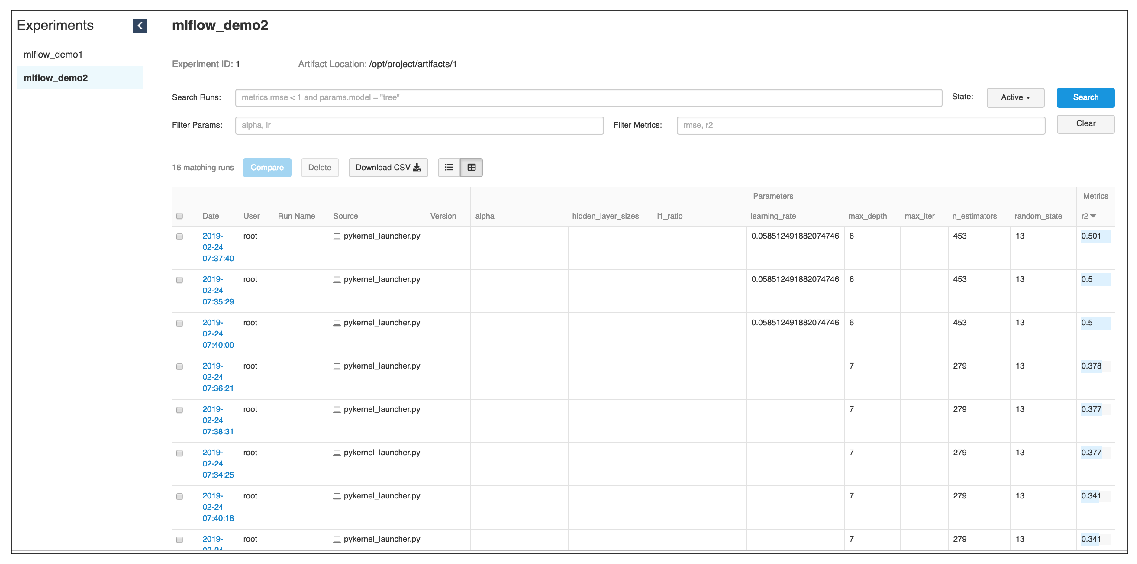

In [11]:
fig = plt.figure(figsize=(20,20))
img = plt.imread('./images/experiment_overview_demo2.png')
plt.xticks([])
plt.yticks([])
plt.imshow(img,figure=fig)